In [4]:
# Imports
import json
import os

import numpy as np
import pandas as pd

In [5]:
# Constants
NSHARDS = 10
RESULTS_DIR = '/tmp/mwe'
LOCALDIR = '/tmp'

MODELS = ['GCN_AttributeMask', 'GCN_', 'GraphSAGE_', 'GraphSAGE_AttributeMask', 
          'GCN_CorruptedEmbeddingsReconstruction', 'GCN_CorruptedFeaturesReconstruction', 'GCN_AutoEncoding']
METRIC = 'test_rocauc_ovr'

In [6]:
dfs = []
for shard_idx in range(NSHARDS):
  filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
  print(filename)

  with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
    lines = f.readlines()
    records = map(json.loads, lines)
    dfs.append(pd.DataFrame.from_records(records))

# Construct df and remove nans
results_df = pd.concat(dfs)
results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
results_df.dropna(axis=0, inplace=True)
del dfs

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [7]:
results_df.columns

Index(['nvertex', 'avg_degree', 'feature_center_distance', 'feature_dim',
       'edge_center_distance', 'edge_feature_dim', 'p_to_q_ratio',
       'num_clusters', 'cluster_size_slope', 'power_exponent',
       ...
       'GCN__test_rocauc_ovo', 'GCN__test_logloss', 'GCN__train_epochs',
       'GCN__train_lr', 'GCN__train_lambda', 'GCN__model_in_channels',
       'GCN__model_hidden_channels', 'GCN__model_num_layers',
       'GCN__model_dropout', 'GCN__model_out_channels'],
      dtype='object', length=122)

In [8]:
type(results_df['GCN_CorruptedFeaturesReconstruction_model_partial_feature_reconstruction'][0])

pandas.core.series.Series

In [9]:
# Function for 1D lineplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def bucket_response_surface1d(results_df, xvar, metric='test_accuracy',
                              group=False, ngrid=25, custom_range=None):
  # BAD_VALS = [np.nan, np.inf, -np.inf]
  # results_df_inner = results_df[~results_df.isin(BAD_VALS).any(1)]
  results_df_inner = results_df.copy(deep=True)
  if custom_range is None:
    min_xvar = np.min(results_df_inner[xvar])
    max_xvar = np.max(results_df_inner[xvar])
  else:
    min_xvar = custom_range[0]
    max_xvar = custom_range[1]
  xrange = np.linspace(min_xvar, max_xvar, ngrid)
  def convert_value(z, range):
    return range[np.argmin(np.abs(range - z))]
  results_df_inner[xvar] = results_df_inner[xvar].apply(convert_value,
                                                        range=xrange)
  if group:
    return results_df_inner.groupby([xvar])[[xvar, metric]].mean()
  else:
    return results_df_inner

def plot_response_surface1d(param, metric, results_df,
                            models=MODELS,
                            reverse_x=False, ci=99):
  bucketed_dfs = []
  index_pos = 0
  grouped_index_pos = 0
  grouped_bucketed_dfs = []
  for model in models:
    model_metric = '%s_%s' % (model, metric)
    if model_metric not in results_df.columns:
      continue

    # Get and store ungrouped bucketed df
    bucketed_df = bucket_response_surface1d(results_df, param,
                                            metric=model_metric,
                                            group=False)
    bucketed_df = bucketed_df.rename(columns={model_metric: metric})
    bucketed_df['model'] = model
    new_index = list(range(index_pos, index_pos + bucketed_df.shape[0]))
    bucketed_df.index = new_index
    bucketed_dfs.append(bucketed_df)
    index_pos += bucketed_df.shape[0]

    # Get and store grouped bucketed df
    grouped_bucketed_df = bucket_response_surface1d(results_df, param,
                                                    metric=model_metric,
                                                    group=True)
    grouped_bucketed_df = grouped_bucketed_df.rename(
        columns={model_metric: metric})
    grouped_bucketed_df['model'] = model
    grouped_new_index = list(range(
        grouped_index_pos, grouped_index_pos + grouped_bucketed_df.shape[0]))
    grouped_bucketed_df.index = grouped_new_index
    grouped_bucketed_dfs.append(grouped_bucketed_df)
    grouped_index_pos += grouped_bucketed_df.shape[0]

    
    
  plot_df = pd.concat(bucketed_dfs, axis=0)

  # Make the plot
  fig = plt.figure(figsize=(10, 10))

  range_x = (np.min(results_df[param]), np.max(results_df[param]))
  if reverse_x:
    range_x = (range_x[1], range_x[0])

  sns.lineplot(data=plot_df, x=param, y=metric, hue="model", ci=ci)
  plt.title('%s vs %s' % (metric, param))
  plt.show()

In [10]:
results_df

nvertex  avg_degree  feature_center_distance  feature_dim  \
0      290    9.667820                 1.440939           16   
0      263   10.273765                 2.386469           16   
0      488    9.237705                 2.027648           16   
0      328    9.701220                 2.628101           16   
0      410   12.838235                 1.874563           16   
0      485    9.723141                 1.264837           16   
0      375    9.064516                 3.440020           16   

   edge_center_distance  edge_feature_dim  p_to_q_ratio  num_clusters  \
0                   2.0                 2     41.448449             4   
0                   2.0                 2     59.936372             4   
0                   2.0                 2     52.964325             4   
0                   2.0                 2     27.028027             4   
0                   2.0                 2     36.458985             4   
0                   2.0                 2     31.928563             4   
0                   2.0                 2     46.871337             4   

   cluster_size_slope  power_exponent  ...  GCN__test_rocauc_ovo  \
0            0.726566             3.0  ...              0.953125   
0            0.917926             3.0  ...              0.500000   
0            0.016797             3.0  ...              0.500000   
0            0.211809             3.0  ...              1.000000   
0            0.490464             3.0  ...              0.500000   
0            0.610148             3.0  ...              1.000000   
0            0.687948             3.0  ...              0.500000   

  GCN__test_logloss  GCN__train_epochs  GCN__train_lr  GCN__train_lambda  \
0          0.610064                 50         0.0100            1000.00   
0          4.239988                 50         0.0001               0.01   
0         13.207446                 50         0.0001             100.00   
0          0.188212                 50         0.0100             100.00   
0         26.356979                 50         0.0001              10.00   
0          0.429284                 50         0.0100               0.01   
0          7.595898                 50         0.0001              50.00   

   GCN__model_in_channels  GCN__model_hidden_channels  GCN__model_num_layers  \
0                      16                           8                      1   
0                      16                          16                      2   
0                      16                          16                      4   
0                      16                           8                      1   
0                      16                          16                      4   
0                      16                           8                      1   
0                      16                          16                      3   

   GCN__model_dropout  GCN__model_out_channels  
0                 0.8                        4  
0                 0.8                        4  
0                 0.0                        4  
0                 0.0                        4  
0                 0.0                        4  
0                 0.5                        4  
0                 0.0                        4  

[7 rows x 122 columns]

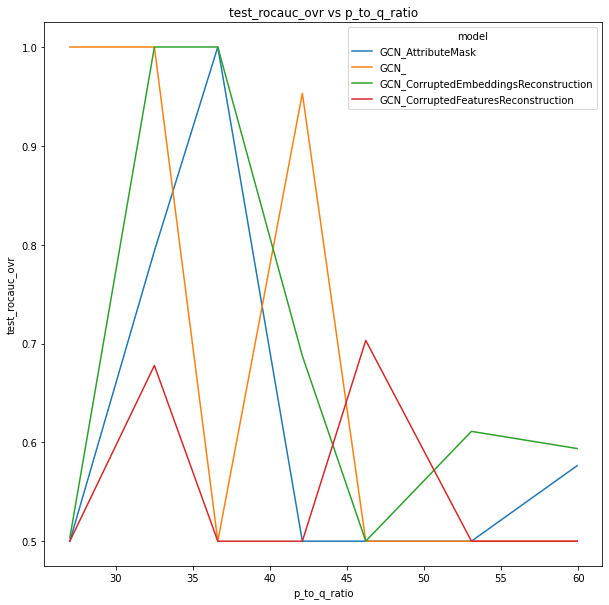

In [11]:
plot_response_surface1d('p_to_q_ratio', METRIC, results_df)